In [23]:
import pandas as pd
import polars as pl
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, brier_score_loss
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from collections import defaultdict
import warnings
from tqdm import tqdm
import pickle

tqdm.pandas()
warnings.filterwarnings("ignore")

In [24]:
year = 20
df_csv = f"./data/CampaignFin20/indivs{year}.txt"
donors_csv = f"./data/CampaignFin{year}/donors{year}.csv"
names_csv = f"./data/USIN_pred_lastname.csv"
pred_csv = f"./output/donors{year}_pred_lastname.csv"

In [25]:
donors = pd.read_csv(donors_csv)
donors["lastname"] = donors["name"].apply(lambda x: str(x).split(",")[0].lower())
donors.head(10)

,contrib_id,name,name_new,orgname,ultorg,gender,occupation,employer,total_donated,donation_count,avg_donation,med_donation,lastname
0,,"FOR AMERICA, AMY",amy for america,[24T Contribution],NaN,,NOT EMPLOYED,NOT EMPLOYED,1.261253e+09,25821,4.884603e+04,1000.0,for america
1,U00000037041,"BLOOMBERG, MICHAEL",michael bloomberg,Bloomberg LP,NaN,M,MAYOR,CITY OF NEW YORK,1.127731e+09,958,1.177172e+06,682.5,bloomberg
2,U00000036521,"STEYER, THOMAS F",thomas f steyer,Fahr LLC/Tom Steyer,Fahr LLC,M,FOUNDER,NEXTGEN AMERICA,3.794782e+08,756,5.019553e+05,2800.0,steyer
3,U00000046841,"MELLON, TIMOTHY",timothy mellon,Investments,NaN,M,INVESTMENTS,SELF,4.513356e+07,23,1.962328e+06,2800.0,mellon
4,U0000000310A,"ADELSON, MIRIAM O DR",miriam o dr adelson,Adelson Clinic for Drug Abuse Treatment & Rese...,NaN,F,PHYSICIAN,ADELSON CLINIC,4.499955e+07,124,3.628996e+05,2800.0,adelson
5,U00000003101,"ADELSON, SHELDON G MR",sheldon g mr adelson,Las Vegas Sands,NaN,M,CHAIRMAN OF THE BOARD,THE VENETIAN,4.484795e+07,119,3.768735e+05,2800.0,adelson
6,U00000036901,"UIHLEIN, RICHARD",richard uihlein,Uline Inc,NaN,M,NaN,NaN,3.536433e+07,319,1.108600e+05,2800.0,uihlein
7,U00000036551,"GRIFFIN, KENNETH",kenneth griffin,Rodimer for Congress,NaN,M,FOUNDER CEO,CITADEL LLC,3.366763e+07,188,1.790832e+05,2800.0,griffin
8,U00000003611,"SCHWARZMAN, STEPHEN A",stephen a schwarzman,Blackstone Group,NaN,M,"CHAIRMAN, CEO & CO-FOUNDER",BLACKSTONE,3.345400e+07,226,1.480265e+05,2800.0,schwarzman
9,U00000046781,"JURVETSON, KARLA",karla jurvetson,[24T Contribution],NaN,F,PHYSICIAN,SELF,3.308810e+07,914,3.620142e+04,2800.0,jurvetson


In [26]:
# https://github.com/philipperemy/name-dataset
df_combined = pd.read_csv(names_csv)
df_combined.head(10)

,name,ethnic,lastname
0,billy morrison,not,morrison
1,ashish agravat,ind,agravat
2,chuck larson,not,larson
3,soheb shaikh,ind,shaikh
4,nick longo,not,longo
5,kundan rao,ind,rao
6,सुजान सोलंकी,ind,सोलंकी
7,melissa rueth,not,rueth
8,george falero,not,falero
9,priya kannan,not,kannan


In [41]:
def calculate_stats(results_test, results_pred, name, display_labels):
    cm = confusion_matrix(results_test, results_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix ({name})')
    plt.show()

    print(f"\n{name}")
    if len(display_labels) > 2:
        accuracy = accuracy_score(results_test, results_pred)
        precision = precision_score(results_test, results_pred, average='weighted')
        recall = recall_score(results_test, results_pred, average='weighted')
        f1 = f1_score(results_test, results_pred, average='weighted')
    else:
        results_pred = np.where(results_pred == "ind", 1, 0)
        results_test = np.where(results_test == "ind", 1, 0)
        accuracy = accuracy_score(results_test, results_pred)
        precision = precision_score(results_test, results_pred, labels=display_labels)
        recall = recall_score(results_test, results_pred, labels=display_labels)
        f1 = f1_score(results_test, results_pred, labels=display_labels)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1:", f1)

In [33]:
def logistic_regression(display_labels):
    logistic_r = LogisticRegression()
    logistic_r.fit(X_train, y_train)
    y_pred = logistic_r.predict(X_test)

    calculate_stats(y_test, y_pred, "Logistic Regression", display_labels)

    return logistic_r

In [29]:
df = df_combined.dropna()
y = df['ethnic']
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df['name'])

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

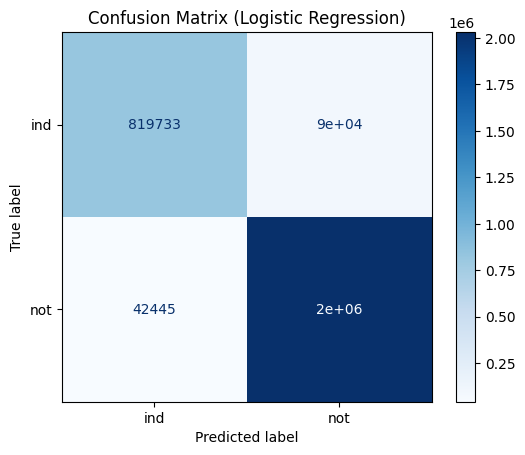


Logistic Regression
Accuracy: 0.9554515116065933
Precision: 0.9507700266070347
Recall: 0.9005778759214704
F1: 0.9249935680723625


In [42]:
prediction = logistic_regression(display_labels=["ind", "not"])

In [43]:
y_probs = prediction.predict_proba(X_test)[:, 1]
y_probs.mean(), y_probs.std()

(0.696171900501986, 0.4172862192022876)

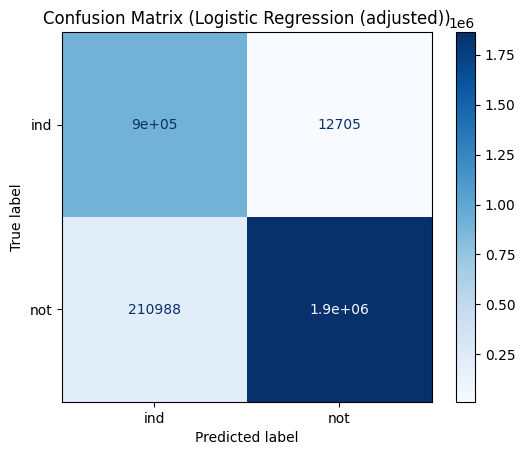


Logistic Regression (adjusted)
Accuracy: 0.9250411080457166
Precision: 0.809665741403123
Recall: 0.9860419893872977
F1: 0.889191937755326


In [46]:
y_pred_adjusted = (y_probs <= 0.85).astype(int)
calculate_stats(y_test, np.where(y_pred_adjusted == 1, "ind", "not"), "Logistic Regression (adjusted)", display_labels=["ind", "not"])

In [47]:
X_topredict = vectorizer.transform(donors['name_new'])
donors_pred = prediction.predict(X_topredict)
donors_pred[:10]

array(['not', 'not', 'not', 'not', 'not', 'not', 'not', 'not', 'not',
       'not'], dtype=object)

In [48]:
donors_probs = prediction.predict_proba(X_topredict)[:, 1]
donors_probs.mean(), donors_probs.std()

(0.9642575281049843, 0.11487793789645151)

In [52]:
donors["ethnic_pred"] = donors_pred
donors["ethnic_prob"] = donors_probs
donors.to_csv(f"./output/donors{year}_pred_logit.csv", index=False)